In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

In [ ]:
def extractSkin(image):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
    skin = cv2.bitwise_and(img, img, mask=skinMask)
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

In [ ]:
def removeBlack(estimator_labels, estimator_cluster):
    hasBlack = False
    occurance_counter = Counter(estimator_labels)
    def compare(x, y): return Counter(x) == Counter(y)

    for x in occurance_counter.most_common(len(estimator_cluster)):
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        if compare(color, [0, 0, 0]) == True:
            del occurance_counter[x[0]]
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)

In [ ]:
def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):
    occurance_counter = None
    colorInformation = []
    hasBlack = False

    if hasThresholding == True:
        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    totalOccurance = sum(occurance_counter.values())

    for x in occurance_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index
        color = estimator_cluster[index].tolist()
        color_percentage = (x[1]/totalOccurance)
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}
        colorInformation.append(colorInfo)

    return colorInformation

In [ ]:
def extractDominantColor(image, number_of_colors=5, hasThresholding=False):
    if hasThresholding == True:
        number_of_colors += 1

    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0]*img.shape[1]), 3)
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)
    estimator.fit(img)
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)

    return colorInformation

In [ ]:
def plotColorBar(colorInformation):
    color_bar = np.zeros((100, 500, 3), dtype="uint8")
    top_x = 0

    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])
        color = tuple(map(int, (x['color'])))
        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x

    return color_bar

In [ ]:
def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()

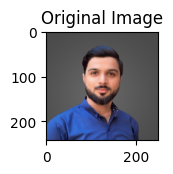

In [ ]:
image = cv2.imread("subhan-liaqat.png")
image = imutils.resize(image, width=250)
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

Text(0.5, 1.0, 'Thresholded  Image')

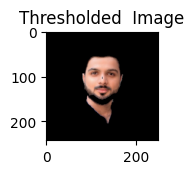

In [ ]:
skin = extractSkin(image)
plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")

Color Information
{'cluster_index': 3,
 'color': [241.71885521884803, 186.34048821548436, 167.56439393939073],
 'color_percentage': 0.28877787254782505}

{'cluster_index': 4,
 'color': [171.93319415448372, 111.00208768266953, 91.67849686847427],
 'color_percentage': 0.23297185329596687}

{'cluster_index': 2,
 'color': [125.88745762711883, 83.30644067796518, 71.44881355932216],
 'color_percentage': 0.18082125015230902}

{'cluster_index': 1,
 'color': [213.09171195651714, 146.37499999999716, 125.55638586956324],
 'color_percentage': 0.17935908370902887}

{'cluster_index': 0,
 'color': [75.51033057851161, 46.831611570247624, 41.75309917355346],
 'color_percentage': 0.11806994029487024}

Color Bar


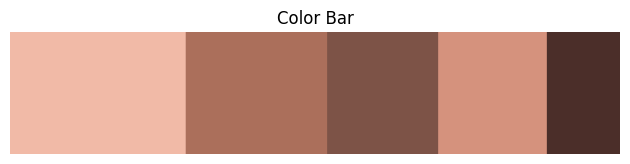

In [ ]:
dominantColors = extractDominantColor(skin, hasThresholding=True)

print("Color Information")
prety_print_data(dominantColors)

print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()